# Capstone Project - Predicting The Risk Of Customer Churn 

## Customer Segmentation Using Unsuprevised Learning - K Means Clustering 
***

### Author - Oyeronke Ayansola

### Date - 12/12/2022

### <font color=red> Notebook #5</font>
***

## Table of Contents
### [Model Goal](##ModelGoal)
### [Conda Environment ](##CondaEnvironment)
### [Import Libraries And Data](##ImportLibrariesAndData)
### [Explore Dataframe](##ExploreAndMergeDataframe)
### [Clustering](##Clustering)
 
### [Models on Train and Validation Sets](##ModelsonTrainandValidationSets)

### [Final Model - Scoring on Test Set](##FinalModel-ScoringonTestSet)
### [Conclusion](##Conclusion)
***

### Model Goal

The primary goal of this model is to segment customers by RFM - recency, frequency and monetary value and separate them into customer group based on clustering. 

If we recall from `notebook 2`, RFM is a customer ranking/grouping technique based on `recency` - how recently has the customer made a transaction, `frequency` - how frequently does the customer place an order and `monetary` - how much money has the customer spent on products. 

### Conda Environment 

For clustering, you will need to set up a new environment as follows:
<br><br>
`conda create --name clustering`
<br><br>
`conda activate clustering`
<br><br>
`conda install python=3.8 jupyter numpy pandas matplotlib seaborn scikit-learn`
<br><br>
`conda install --channel districtdatalabs yellowbrick`
<br><br>

### Import Libraries and Data

First, we need to import the neccessary packages. 

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# standard scaler
from sklearn.preprocessing import StandardScaler

# unsupervised learning models
from sklearn.cluster import KMeans

# silhouette score
from sklearn.metrics import silhouette_score

# silhouette_visualizer from yellowbrick.cluster
from yellowbrick.cluster import silhouette_visualizer, kelbow_visualizer

#Some of these packages will generate a ton of warnings...
import warnings
warnings.filterwarnings("ignore")


Let us load the dataset we will be using. The data was created in `Notebook #2` as rfm csv file.

In [2]:
# load the dataframe
df = pd.read_csv('rfm_df.csv')

### Explore Dataframe

In [3]:
# see the shape of our data
df.shape

(91019, 4)

The data has 92,938 rows and 4 columns.

In [4]:
# check the first few rows
df.head()

,customer_unique_id,frequency,recency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,111,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,113,27.19
2,0000f46a3911fa3c0805444483337064,1,536,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1,320,43.62
4,0004aac84e0df4da2b147fca70cf8255,1,287,196.89


In [5]:
# check for duplicates
df.duplicated().any()

False

In [6]:
# check null values
df.isna().sum()

customer_unique_id    0
frequency             0
recency               0
monetary              0
dtype: int64

There is no duplicate or null values in our data.

In [7]:
# let us see if the columns are correlated
df.corr()

,frequency,recency,monetary
frequency,1.000000,0.006351,0.379300
recency,0.006351,1.000000,-0.004219
monetary,0.379300,-0.004219,1.000000


They do not seem to correlate, we can visually see this as well.

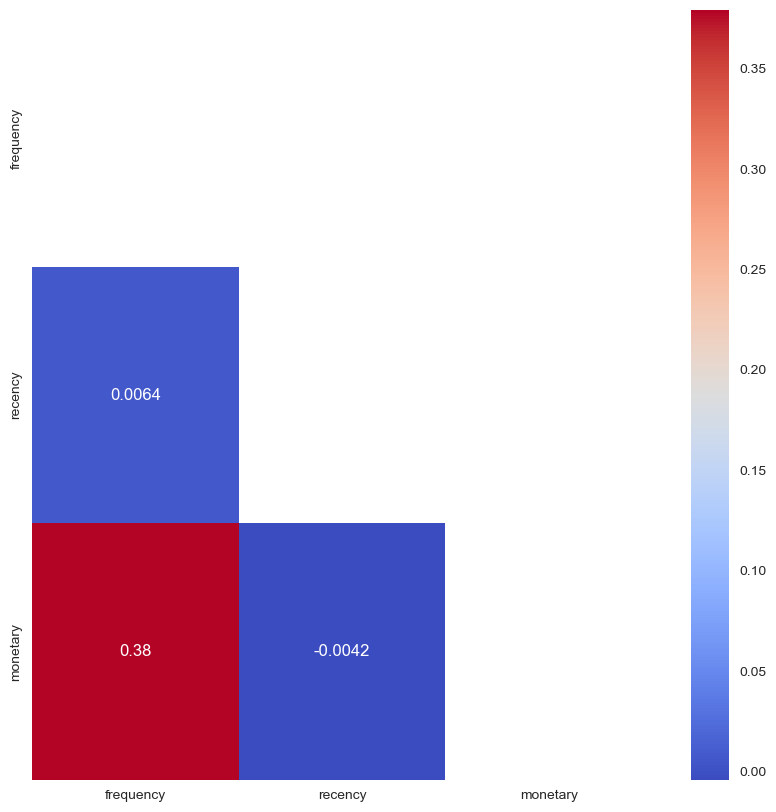

In [8]:
# Visualising correlation with heatmap
mask = np.triu(df.corr())

plt.figure(figsize= (10,10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, mask = mask)
plt.show()

The values are not correlated, all values are less than 0.5. Among the three (RFM), monetary and frequency has the highest correlation of 0.38 (this is expected - the more a customer visit olist, the more money they spent), but the value is still less than 0.5.

In [9]:
# check the datatype
df.dtypes

customer_unique_id     object
frequency               int64
recency                 int64
monetary              float64
dtype: object

Customer_unique_id is the row-level unique customer identifier, therefore we will set as the dataframe index.

In [10]:
# Re-read the data and set customer_unique_id as index
df = pd.read_csv('rfm_df.csv', index_col='customer_unique_id')

In [12]:
# sanity check
df.head()

,frequency,recency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,111,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,113,27.19
0000f46a3911fa3c0805444483337064,1,536,86.22
0000f6ccb0745a6a4b88665a16c9f078,1,320,43.62
0004aac84e0df4da2b147fca70cf8255,1,287,196.89


In [13]:
# check the unique values in frequency
df['frequency'].unique()

array([ 1,  2,  4,  3,  7,  5,  6, 12, 15,  8, 10, 18, 11,  9, 14, 24, 19,
       22, 20, 21, 26, 16, 38, 13, 75, 35])

The frequency ranges from once to 75 times customers patronised Olist.

In [14]:
# check for missing values
df.isnull().sum()

frequency    0
recency      0
monetary     0
dtype: int64

Let us check the distribution of our dataframe.

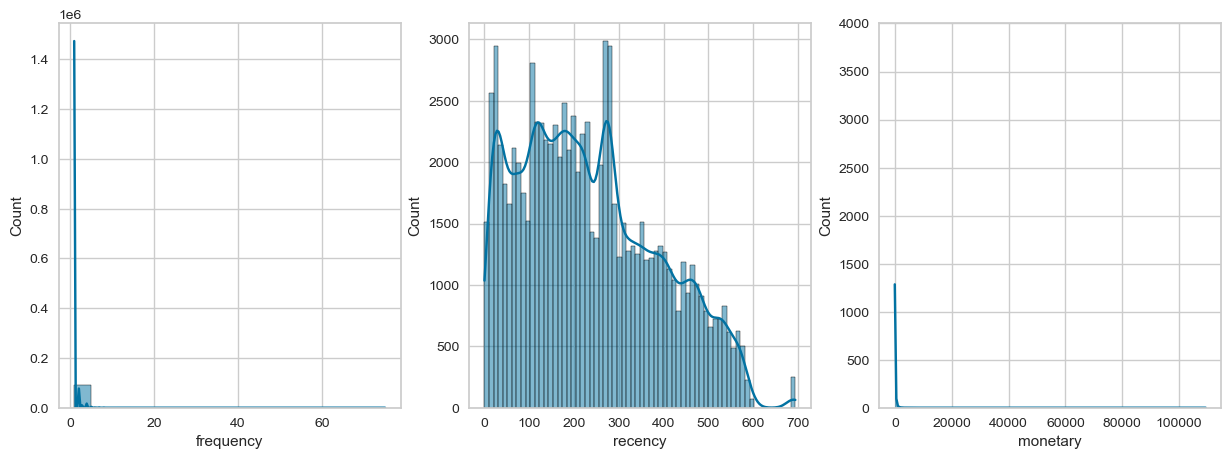

In [15]:
fig, ax = plt.subplots(nrows = 1 , ncols = 3, figsize = (15,5))

# frequecy
sns.histplot(df['frequency'], kde = True, ax = ax[0])

# recency
sns.histplot(df['recency'], kde = True, ax = ax[1])

# monetary
sns.histplot(df['monetary'], kde = True, ax = ax[2])

plt.show()


The distribution of monetary and frequency appears to be really skewed to the left, likewise recency which spreads across the x-aixs but still left skewed. We will transform using a logscale for all columns to make the distributions more even. This may help the clustering methods as they are all distance based.

In [16]:
# Log scale ALL columns, add 1 to avoid taking the log of 0
df2 = np.log(df + 1)

In [17]:
# sanity check
df2.isnull().sum()

frequency    0
recency      0
monetary     0
dtype: int64

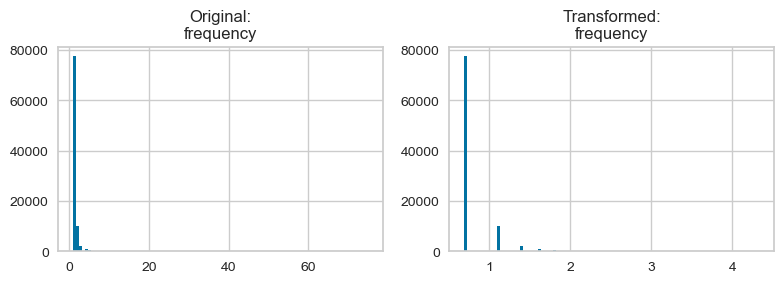

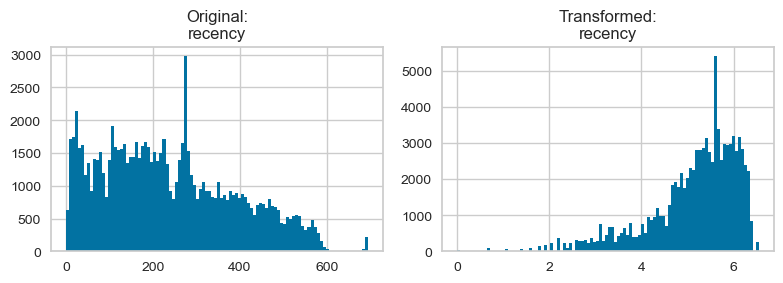

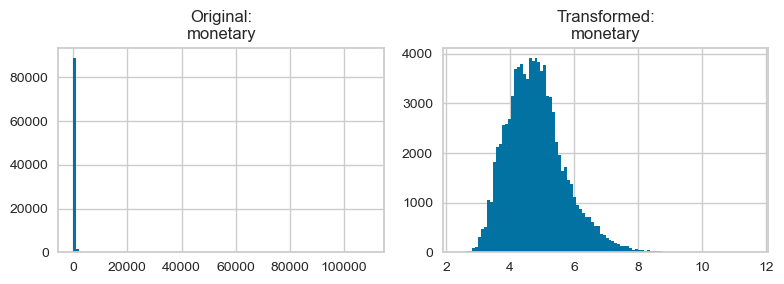

In [18]:
for column in df2.columns:
    plt.subplots(1, 2, figsize=(8, 3))
    plt.tight_layout()
    
    plt.subplot(1, 2, 1)
    plt.title(f"Original:\n{column}")
    plt.hist(df[column], bins=100)
    
    plt.subplot(1, 2, 2)
    plt.title(f"Transformed:\n{column}")
    plt.hist(df2[column], bins=100)
    plt.tight_layout()
    plt.show()

The transformation has helped the monetary distribution look more normal, however frequency distribution still look the same, and recency is skewed to the right. We will proceed with the transformed dataframe.

Next, we will need to scale our data since **K-means clustering** is a distance-based algorithm, we will employ StandardScaler.

In [19]:
# instantiate and fit scaler
scaler = StandardScaler().fit(df2)

# transform
df2_scaled =scaler.transform(df2)

In [20]:
# inspect the scaled data
pd.DataFrame(df2_scaled, columns=df2.columns)

,frequency,recency,monetary
0,-0.371139,-0.444552,0.164276
1,-0.371139,-0.426110,-1.622129
2,-0.371139,1.188741,-0.379083
3,-0.371139,0.652586,-1.116736
4,-0.371139,0.539552,0.522582
...,...,...,...
91014,1.495499,0.997602,3.867994
91015,-0.371139,0.440965,-0.399974
91016,-0.371139,1.247220,-0.089617
91017,-0.371139,-0.381383,0.099157


### Clustering

Let us now use K-means clustering to segment our data. First we need to determine the best `k-value` to use. We will loop over some range of values and plot a `scree plot` to determine the best k-value.

In [21]:
# loop model across different values of 'k'
k_values = np.arange(1,11)

inertia = []

for k in k_values:
    km = KMeans(n_clusters=k)
    km.fit(df2_scaled)
    inertia.append(km.inertia_)

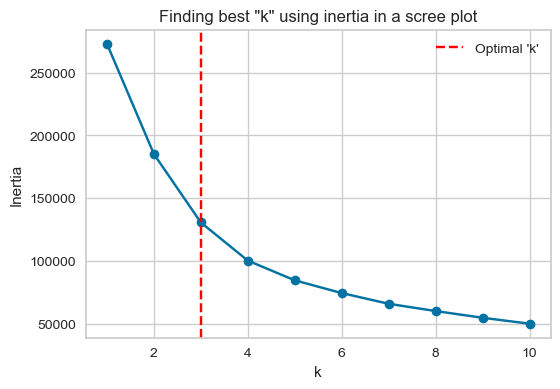

In [22]:
# plot inertia by 'k' value
plt.figure(figsize=(6,4))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Finding best "k" using inertia in a scree plot')
plt.axvline(3, label="Optimal 'k'", color='red', linestyle='--')
plt.legend()
plt.show()

From the `elbow method` for the scree plot above, although the elbow appears to be on `k=3`, we can also argue same for between `k=2` to `k=5`. Because we are not crystal clear, we will explore silhouette score.

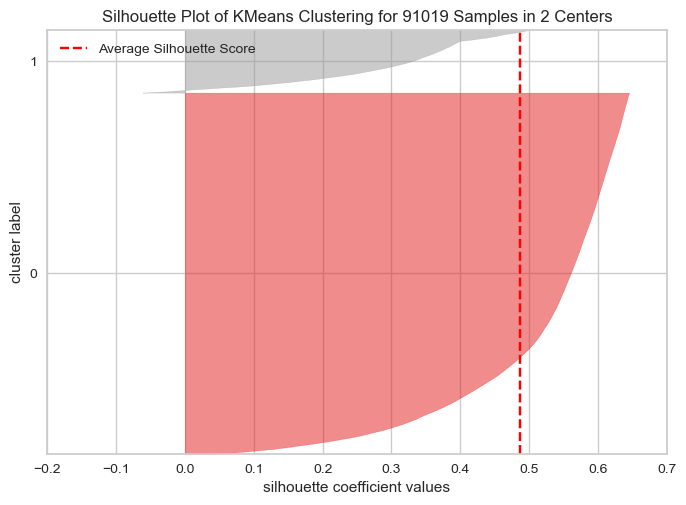

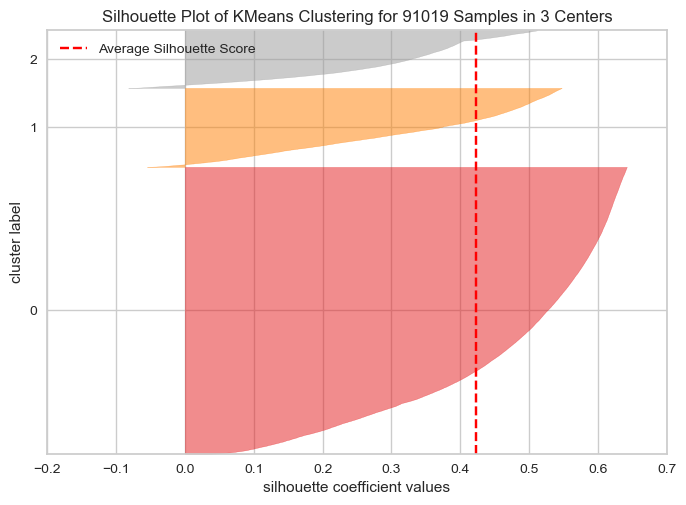

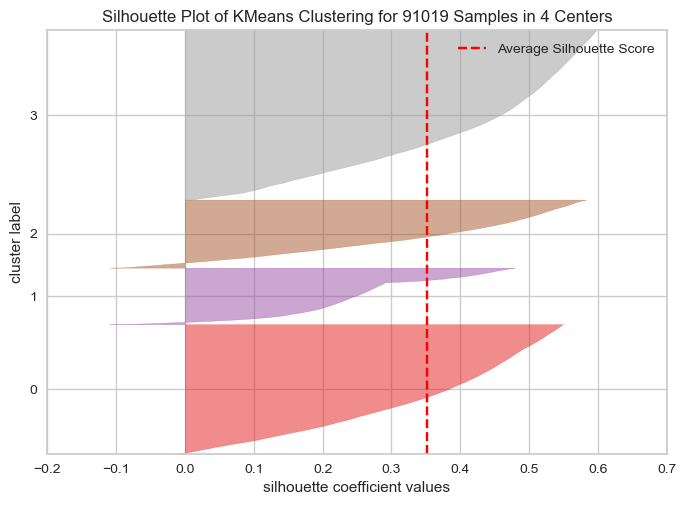

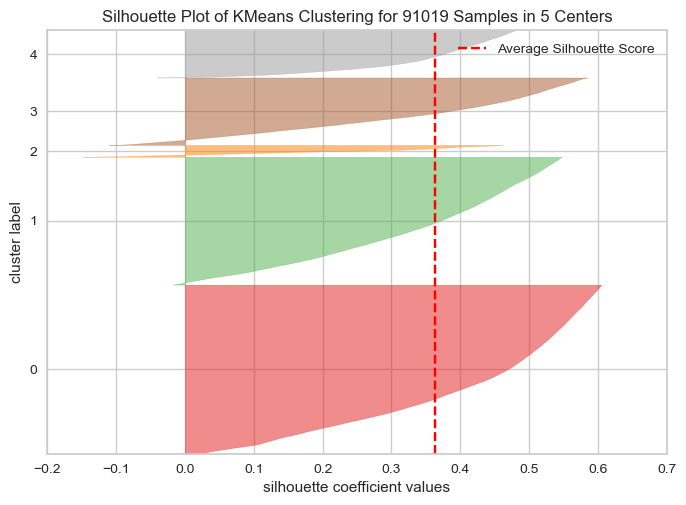

In [23]:
# visualizing silhouette scores for focus k-values
for k in range (2,6):
    silhouette_visualizer(KMeans(n_clusters=k, random_state=42), df2_scaled);

We observe that the highest silhouette score is for 2 clusters although there is an obvious imbalance in the cluster sizes. Let us look at the silhoutte score plot and increase our kmeans from 6 above to 11.

In [24]:
# We will explore different values for k, and look at the scree plot ('elbow method') 
# using inertia. We will also look at the silhouette score

ks = np.arange(2, 11)

silhouette_score_list = []

for k in ks:

    # Instantiate
    my_kmeans = KMeans(n_clusters=k)
    
    # Fit (i.e. get clusters)
    y_labels = my_kmeans.fit_predict(df2_scaled)    

    # Append silhouette
    silhouette = silhouette_score(df2_scaled, y_labels)
    silhouette_score_list.append(silhouette)

    print(f"Computed Score for k={k}")

Computed Score for k=2
Computed Score for k=3
Computed Score for k=4
Computed Score for k=5
Computed Score for k=6
Computed Score for k=7
Computed Score for k=8
Computed Score for k=9
Computed Score for k=10


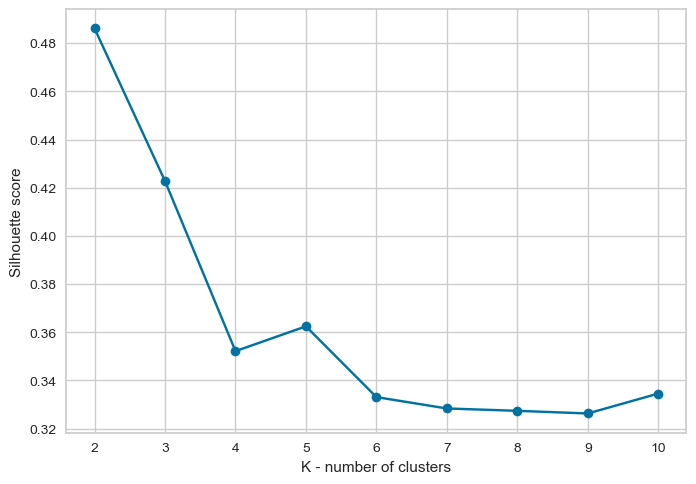

In [25]:
# visualize the silhouette scores
plt.figure()
plt.plot(ks, silhouette_score_list, marker='o')
plt.xlabel('K - number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(ks)
plt.show()

From the silhouette score, it appears k-number of clusters is optimal at 2, followed by 5. We will setour number of cluster to 2.

In [26]:
# set cluster number and fit model 
final_model = KMeans(n_clusters = 2, random_state = 123)
final_model.fit(df2_scaled)

KMeans(n_clusters=2, random_state=123)

In [27]:
# sanity check
final_model.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

Next, we will add the cluster number generated to our main dataframe.

In [28]:
# make a copy of original dataframe
data_output = df.copy()

# add clusters as a column
data_output['clusters'] = final_model.labels_

# check the new output dataframe
data_output.sample(10)

,frequency,recency,monetary,clusters
customer_unique_id,,,,
975ddc2c0783f56801492449ceea1a88,1,415,116.85,0
128879fb7a67cfdb05d5e1fe5a37e989,1,110,686.41,0
c7fa86b24c5659adf36cb075a5e27459,1,295,94.31,0
03820299130367803663f7eb70bcf2bc,2,11,273.72,1
e21df4d25b6fa4216c2f25bff216b4cc,1,189,466.90,0
68a01a970a892626b445cdfad671db62,1,97,349.18,0
016c60628fc64e15fa5990e58a0b57c1,3,404,913.68,1
efd751d25a1eee58e3718c7af7a3ba79,3,102,599.37,1
659140cc3652500a815b4e14b50d3335,1,502,166.11,0


Let us now calculate the average of recency, frequency and monetary while counting and group RFM by the clusters.

In [29]:
# get the average of RFM and group by clusters
rfm_agg = data_output.groupby(['clusters']).agg({
    'recency': 'mean',
    'frequency': 'mean', 
    'monetary': 'mean',
    'clusters': 'count'
}).round(2)

rfm_agg.rename(columns = {"recency": "Recency",
                          "frequency": "Frequency",
                          "monetary": "Monetary",
                          "clusters": "Customer Count"
                         }, inplace = True)

rfm_agg

,Recency,Frequency,Monetary,Customer Count
clusters,,,,
0,235.49,1.01,140.38,77625
1,236.72,2.56,629.58,13394


We have two groups with 
1. monetary - high spenders and medium spenders
2. frequency - once and ~ 3 times frequent customers
3. recency - not much of segmentation, both are very close

With the clear distinct in monetary clusters, and very close recency values, is it possible that the clustering was based on outliers if there is any?

Let us examine the outliers and median and range distribution of our dataframe.

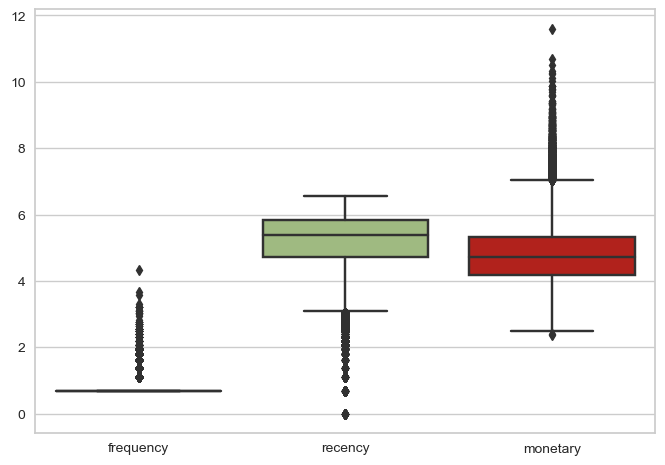

In [30]:
sns.boxplot(df2)
plt.show()

It seems the data has outliers, but not as much as the value grouped by our cluster result for cluster 1. (i.e cluster 1 - 13674).

Let us have a look at a 3D graph if we can make more sense out of it.

In [31]:
# get log of cluster dataframe
data_output2 = np.log(data_output + 1)

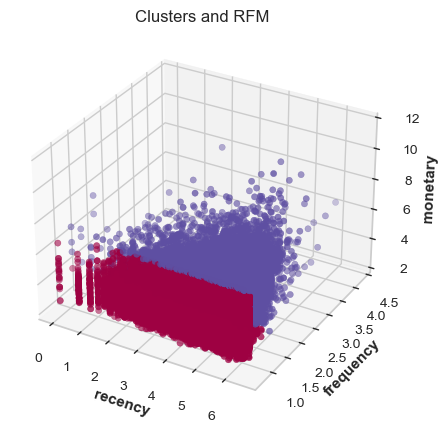

In [32]:
# plot a 3D graph
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt



fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(data_output2['recency'], data_output2['frequency'],data_output2['monetary'],  c=data_output2['clusters'], cmap="Spectral", label=data_output2['clusters'])
ax.set_xlabel('recency', fontweight ='bold')
ax.set_zlabel('monetary', fontweight ='bold')
ax.set_ylabel('frequency', fontweight ='bold')
ax.set_title('Clusters and RFM')

plt.show()

We have clusters which is more likely that the base values were separated from the rest. We are not sure the customers were properly segmented.

Let us visualise this better with sns plot.

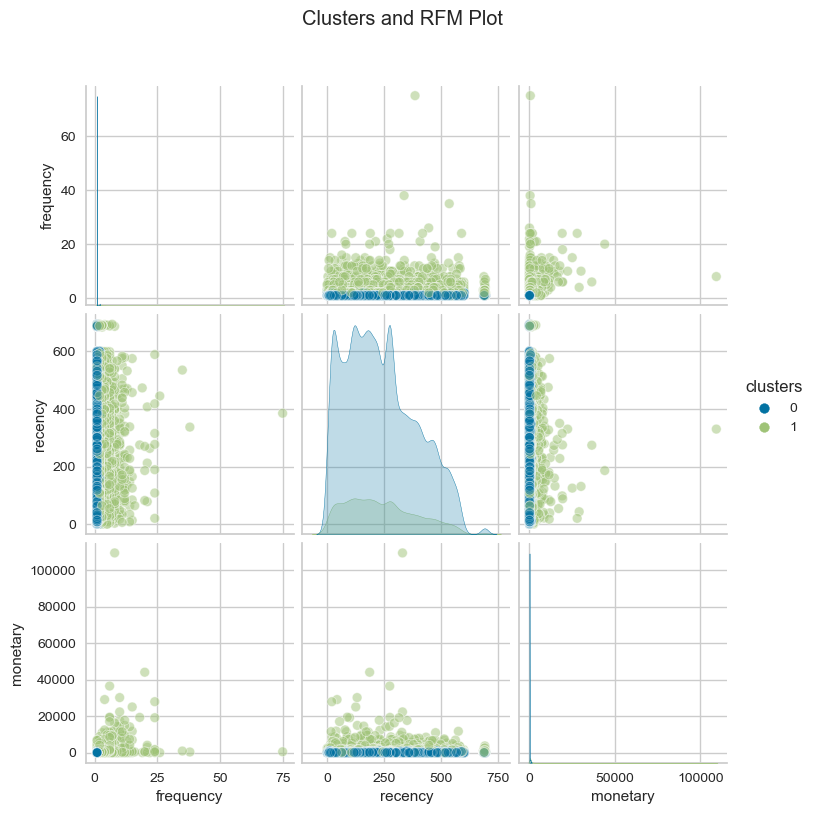

In [33]:
# sns cluster plot
fig = sns.pairplot(data_output, hue="clusters", plot_kws={'alpha': 0.5})

fig.fig.suptitle("Clusters and RFM Plot", y=1.08)
plt.show()

It is now clear our clustering was based on 'basal' separation. Let us use the next silhouette score for our number of clusters, that is 5.

In [34]:
# set cluster number and fit model 
final_model = KMeans(n_clusters = 5, random_state = 123)
final_model.fit(df2_scaled)

KMeans(n_clusters=5, random_state=123)

In [35]:
# sanity check
final_model.labels_

array([0, 1, 1, ..., 1, 0, 1], dtype=int32)

In [36]:
# make a copy of original dataframe
data_output = df.copy()

# add clusters as a column
data_output['clusters'] = final_model.labels_

# check the new output dataframe
data_output.sample(10)

,frequency,recency,monetary,clusters
customer_unique_id,,,,
d590ddf189371b577fc2f8d1d57dd3c0,1,479,45.49,1
10173afeb5a938917553c2cbdabf238a,1,527,166.11,0
c6c1e34c95f90df749addda9751d51d9,1,28,37.37,2
9c9e34e36d16ec0e457aecffc9a27d85,2,525,131.80,4
bff7213ed01da37603d10a1efe89d417,2,337,55.09,4
4ed413aee1c65e98a025d2ee754aa687,1,563,245.68,0
968eb2d1f935ee98a92ccb091c6225dc,1,376,49.13,1
4f7a81a0b04edaf86ec4c88c9208eccf,1,498,287.62,0
7d23ca9b9d5f41298ec3ccbb2ff637d8,3,200,185.19,4


Let us now calculate the average of recency, frequency and monetary while counting and group RFM by the clusters.

In [37]:
# get the average of RFM and group by clusters
rfm_agg = data_output.groupby(['clusters']).agg({
    'recency': 'mean',
    'frequency': 'mean', 
    'monetary': 'mean',
    'clusters': 'count'
}).round(2)

rfm_agg.rename(columns = {"recency": "Recency",
                          "frequency": "Frequency",
                          "monetary": "Monetary",
                          "clusters": "Customer Count"
                         }, inplace = True)

rfm_agg

,Recency,Frequency,Monetary,Customer Count
clusters,,,,
0,272.33,1.00,273.67,27422
1,282.68,1.01,64.34,36412
2,38.12,1.05,137.22,14492
3,231.45,4.64,1540.96,2549
4,251.13,2.12,351.50,10144


We now have five groups with 

1. monetary - very high spenders (1552.88), very low (65.45), low (135.74) and medium spenders (355.33)
2. frequency - once, ~ 2 and ~ 5 times frequent customers
3. recency - we have customers how are pretty new (47.26) and rest less that one year old.


Let us have a look at the 3D plot cluster and sns plot.

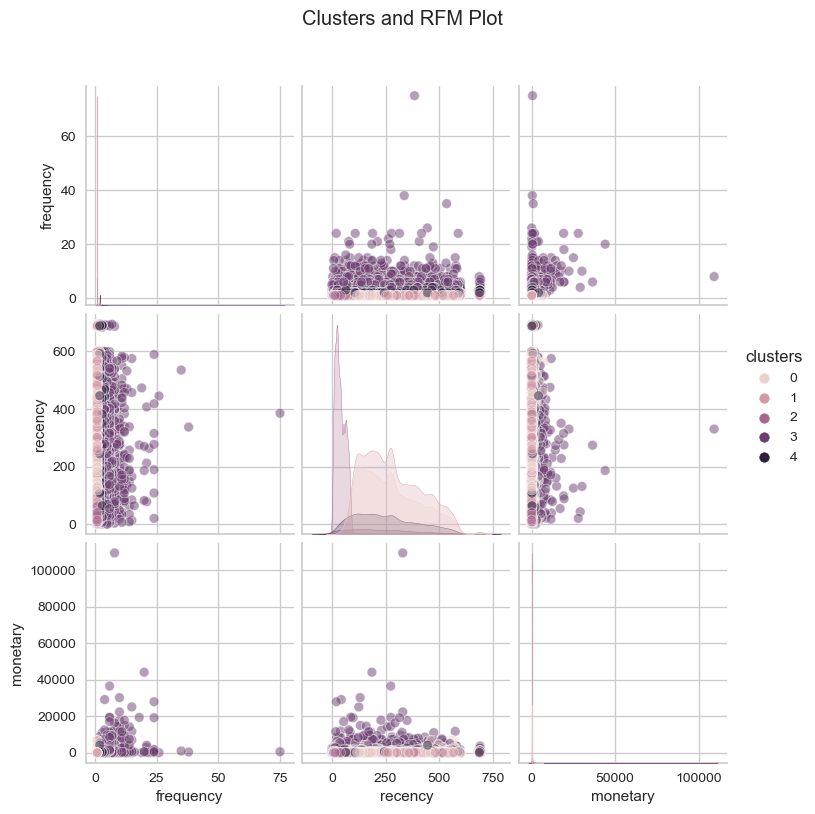

In [38]:
# sns cluster plot
fig = sns.pairplot(data_output, hue="clusters", plot_kws={'alpha': 0.5})

fig.fig.suptitle("Clusters and RFM Plot", y=1.08)  

plt.show()

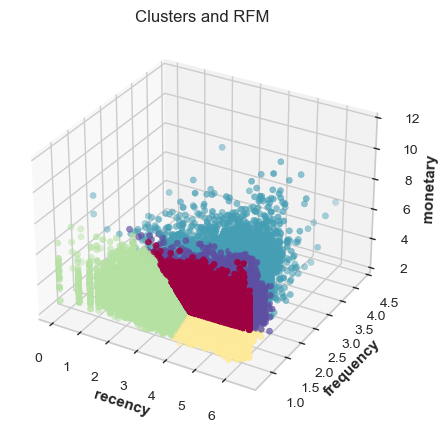

In [39]:
# plot 3D graph
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt


data_output2 = np.log(data_output + 1)


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(data_output2['recency'], data_output2['frequency'],data_output2['monetary'],  c=data_output2['clusters'], cmap="Spectral", label=data_output2['clusters'])
ax.set_xlabel('recency', fontweight ='bold')
ax.set_zlabel('monetary', fontweight ='bold')
ax.set_ylabel('frequency', fontweight ='bold')
ax.set_title('Clusters and RFM')

plt.show()

We have a better, although not very distinct clusters, but seems better that before. We can segment our customers based on the above clusters information. We can also plot out the number of customers based on the cluster group.

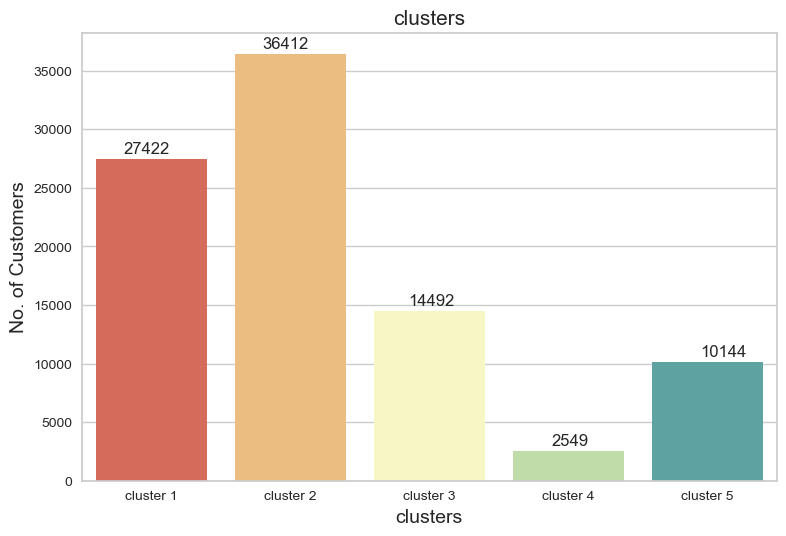

In [40]:
# cluster- customer plot 
sns.countplot(data = data_output, x = 'clusters', palette = 'Spectral')
plt.title('clusters', fontsize = 15)
plt.xlabel('clusters', fontsize = 14)
plt.ylabel('No. of Customers', fontsize = 14)
plt.xticks([0,1,2,3, 4], ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5'], rotation = 0)
plt.text(x = 0 - 0.2, y = data_output.clusters.value_counts()[0] + 500, s = data_output.clusters.value_counts()[0])
plt.text(x = 1 - 0.2, y = data_output.clusters.value_counts()[1] + 500, s = data_output.clusters.value_counts()[1])
plt.text(x = 2 - 0.15, y = data_output.clusters.value_counts()[2] + 500, s = data_output.clusters.value_counts()[2])
plt.text(x = 3 - 0.12, y = data_output.clusters.value_counts()[3] + 500, s = data_output.clusters.value_counts()[3])
plt.text(x = 4 - 0.05, y = data_output.clusters.value_counts()[4] + 500, s = data_output.clusters.value_counts()[4])
plt.tight_layout(pad = 1)
plt.show()

We have the lowest number of customers at cluster 3, next at 5, followed by 1 then 2 and highest at 4.

### Conclusion

In this notebook, we succeeded in segmenting Olist customers as follows:

1. **cluster 1** possibly new customers, low spenders
2. **cluster 2** moderate spenders, not so loyal
3. **cluster 3** very loyal customers, very high spenders
4. **cluster 4** very low spenders, not loyal 
5. **cluster 5** high spenders, somewhat loyal

We may want to keep the customers in clusters 3 and 5 by all means.
